### Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.  
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.   
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.  
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

In [ ]:
#pip install Fast_ml
#pip install tqdm

### Импорт бибилиотек

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle

### Загрузка датасета

In [146]:
try:
    df = pd.read_csv('./datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* В столбце Tenure не хватает около 1000 строк
* 3 классовых столбца (object) остальные - числовые
* Rownumber, CustomerId, Surname для модели использовать не будем, т.к. это уникальные значения, не являющиеся характиристиками заемщика.
* Можно перевести столбец IsActiveMember в булевый формат

In [148]:
df['IsActiveMember']=df['IsActiveMember'].astype('bool') #Изменим тип данных на булевый, чтобы меньше нагружать пк.
df['Exited']=df['Exited'].astype('bool')
df['HasCrCard']=df['HasCrCard'].astype('bool')

In [149]:
df[df['Tenure'].isna()].head(10) #Есть смысл посмотреть другие столбцы, где Tenure = NA

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,True,False,140469.38,True
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,False,True,90878.13,False
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,False,False,86424.57,False
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,False,False,164040.94,True
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,False,False,84509.57,False
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,False,False,26019.59,False
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,True,True,114675.75,False
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,False,True,85982.47,False
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,False,False,6534.18,False
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,True,False,27231.26,False


Какой-либо закономерностей я тут не увидел. Поэтому построим гистограмму столбца Tenure

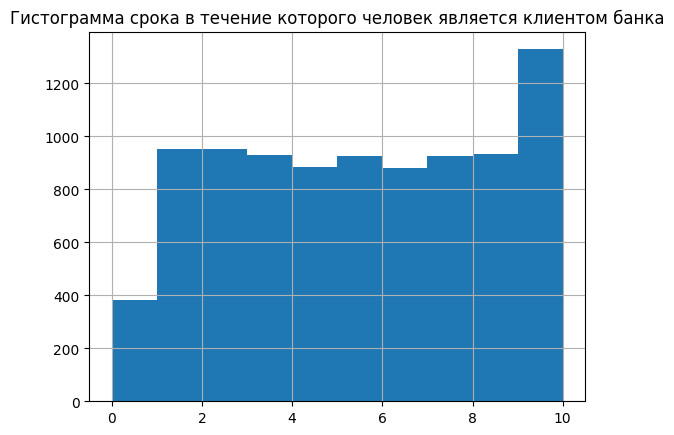

In [150]:
df['Tenure'].hist(bins = 10)
plt.title('Гистограмма срока в течение которого человек является клиентом банка')
plt.show()

Люди распределены довольно равномерно, чуть меньше людей только начали пользоваться банком и больше людей, которые уже 10 лет являются его клиентами.
Для начала заполним пропуски медианой, если этот способ не даст достаточной точности при построении модели, можно исопльзовать и другие варианты.

In [151]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [152]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.99790,76485.889288,1.530200,100090.239881
std,2886.89568,7.193619e+04,96.653299,10.487806,2.76001,62397.405202,0.581654,57510.492818
min,1.00000,1.556570e+07,350.000000,18.000000,0.00000,0.000000,1.000000,11.580000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.00000,0.000000,1.000000,51002.110000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.00000,97198.540000,1.000000,100193.915000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.00000,127644.240000,2.000000,149388.247500
max,10000.00000,1.581569e+07,850.000000,92.000000,10.00000,250898.090000,4.000000,199992.480000


* Первые 2 столбца нас не интересуют. Т.к. это идентификаторы, не содержащие полезной информации для модели.
* CreditScore потребует масштабирования как и другие числовые столбцы
* Явных аномалий на данной стадии не выявлено


In [153]:
df.duplicated().sum()

0

* Явных дубликатов нет

### Подготовка данных для моделей

In [154]:
df_ml = df.drop(['RowNumber','CustomerId','Surname'],axis = 1) #Удаляем прядковые столбцы, которые не нужны в модели
df_ml = pd.get_dummies(df_ml, drop_first=True) #Преобразуем категориальные данные методом Ohe
features = df_ml.drop(['Exited'],axis=1)
target = df_ml['Exited']
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
    df_ml, target = 'Exited', train_size=0.6, valid_size=0.2, test_size=0.2)#Разделим данные на 3 группы в соотношении 80-10-10

In [155]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5947,656,45,7.0,145933.27,1,True,True,199392.14,0,0,0
1754,724,33,5.0,103564.83,2,True,False,121085.72,1,0,1
6018,731,30,7.0,0.00,2,False,True,143086.09,0,0,1
9542,644,37,9.0,0.00,2,True,True,96442.86,0,1,1
4208,447,44,5.0,89188.83,1,True,True,75408.24,0,0,0


In [156]:
#Отберем числовые поля
numeric = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5947,0.056054,0.571489,0.722515,1.116713,-0.907399,True,True,1.729337,0,0,0
1754,0.754454,-0.575919,-0.000422,0.438290,0.796103,True,False,0.371644,1,0,1
6018,0.826348,-0.862771,0.722515,-1.220040,0.796103,False,True,0.753091,0,0,1
9542,-0.067194,-0.193450,1.445451,-1.220040,0.796103,True,True,-0.055619,0,1,1
4208,-2.090502,0.475871,-0.000422,0.208094,-0.907399,True,True,-0.420321,0,0,0


In [157]:
y_train.value_counts(normalize=True)

False    0.798167
True     0.201833
Name: Exited, dtype: float64

Наблюдается дисбаланс, необходимо увеличить количество положительных данных, используя технику upsampling

In [158]:
def upsample(features, target, repeat):
    features_zeros = features[target == False]
    features_ones = features[target == True]
    target_zeros = target[target == False]
    target_ones = target[target == True]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)


In [159]:
y_upsampled.value_counts(normalize=True)

False    0.56863
True     0.43137
Name: Exited, dtype: float64

Отлично, теперь группы в тестовой выборки примерно одинаковые.

### Модель случайный лес

In [160]:
best_result = 0
best_est = 0
for est in range (1,105,5):
    model_RF = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_RF.fit(X_upsampled, y_upsampled)
    RF_prediction = model_RF.predict(X_valid)
    result = model_RF.score(X_valid, y_valid)
    if result > best_result:
        best_est = est
        best_result = result
        best_model = model_RF
        best_pred = RF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"est =", best_est)
print ('Модель "Случайный лес: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred)))
print("Полнота" , recall_score(y_valid, best_pred))
print("Точность", precision_score(y_valid, best_pred))
print("F1-мера", f1_score(y_valid, best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.8695 est = 31
Модель "Случайный лес: Метрики качества:


,0,1
0,1512,84
1,177,227


Полнота 0.5618811881188119
Точность 0.729903536977492
F1-мера 0.6349650349650351


Апсемплинг позволил улучшить качество модели, посмотрим на остальные модели
Мы сразу уложились в таргет, F1 > 60%

### Модель "Логическая регрессия"

In [161]:
model_LR = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_LR.fit(X_upsampled, y_upsampled)
LR_prediction = model_LR.predict(X_valid)
print ('Модель "Логическая регрессия: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, LR_prediction)))
print("Полнота" , recall_score(y_valid, LR_prediction))
print("Точность", precision_score(y_valid, LR_prediction))
print("F1-мера", f1_score(y_valid, LR_prediction))

Модель "Логическая регрессия: Метрики качества:


,0,1
0,1290,306
1,157,247


Полнота 0.6113861386138614
Точность 0.44665461121157324
F1-мера 0.5161964472309298


Очень слабый результат. Линейная модель дала бы лучше результат, чем регрессия

### Модель "Дерево решений"

In [162]:
best_result = 0
best_depth = 0
for depth in range (1,6):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_DR.fit(X_upsampled, y_upsampled)
    DF_prediction = model_DR.predict(X_valid)
    result = model_RF.score(X_valid, y_valid)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_est)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))

Accuracy наилучшей модели на валидационной выборке: 0.863 max_depth = 31
Модель "Дерево решений: Метрики качества:


,0,1
0,1225,371
1,151,253


Полнота 0.6262376237623762
Точность 0.40544871794871795
F1-мера 0.49221789883268485


Тоже низкий результат. Очень часто дает негативные предсказания, значение True.  
По итогам этапа валидации оставляем модель случайного леса.
Проверим его не тестовой выборке

In [163]:
best_pred_final = model_RF.predict(X_test)
print ('Модель "Случайный лес: Метрики качества на тестовой выборке:')
display(pd.DataFrame(confusion_matrix(y_test, best_pred_final)))
print("Полнота" , recall_score(y_test, best_pred_final))
print("Точность", precision_score(y_test, best_pred_final))
print("F1-мера", f1_score(y_test, best_pred_final))

Модель "Случайный лес: Метрики качества на тестовой выборке:


,0,1
0,1471,107
1,194,228


Полнота 0.5402843601895735
Точность 0.6805970149253732
F1-мера 0.6023778071334215


Модель стабильно отработала и на тестовой выборке.
Теперь проверим ее на адекватность, сравнив с константой

In [164]:
probabilities_test = model_RF.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

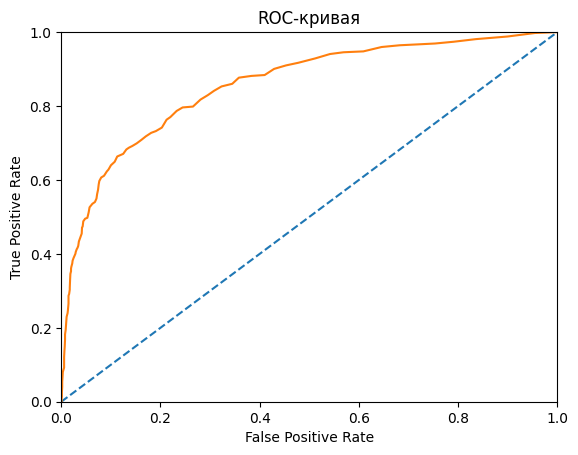

In [165]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Отлично, мы видим, что наша модель работает гораздо лучше, а ее качественные показатели попали в таргет.

### Выводы

* В полученном датасете в одном из полей отсутствовали значения. Изучив список было принятно решение заполнить пропуски медианным значением.
* На этапе валидации была выбрана модель "Случайный лес", т.к. ее показатели были значительно выше других моделей. F1 score составил 63.4%
* В ходе работы над моделью выяснилось, что целевой столбец содержит только 20% положительных ответов, в результате чего был использован метод upsample
* При тестировании на тестовой выборке модель также отлично справилась, f1 score получилось 60,2%